# Likelihood ratio test vs. Fisher matrix

Example to compare the results from Likelihood ratio test (profile likelihood) and Fisher matrix methods. 
For this, we obtain constraints (68.27% contour) on the cold dark matter density $\Omega_c$ and the dark energy equation 
of state $w$ parameters, where $w =$ constant, using type Ia supernova (SNeIa) and baryon acoustic oscillations (BAO) data.

## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries. We also load some Python packages.

In [2]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### Initializing the NumCosmo library:

In [3]:
Ncm.cfg_init ()

### Initializing the objects

We first initialize the **NcHICosmo** object. It describes a cosmological model assuming a homogeneous and isotropic metric of the background. 

In particular, we initialize a **NcHICosmo** child whose Dark Energy (DE) component is described by a barotropic fluid with constant equation of state, **NcHICosmoDEXcdm**.

One choice we make here is to parametrize the problem considering the curvature density parameter, $\Omega_k$, instead of the DE density parameter $\Omega_{DE}$. 
We then set the values for the others cosmological parameters: 
1. The Hubble constant $H_0$;
2. The DE equation of state parameter $w$;
3. The baryon density parameter $\Omega_b$;
4. The cold dark matter density parameter $\Omega_c$;
5. The mass(es) of the neutrino(s) $m_{\nu}$;
6. The effective number of massless neutrinos $N_{\nu}$;
7. The temperature of the photons today $T_{\gamma 0}$.

The parameters that are not set here kepp the default values.

In [4]:
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<1>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        67.66)
cosmo.param_set_by_name ("Omegak",    0.0)
cosmo.param_set_by_name ("w",         -0.8)
cosmo.param_set_by_name ("Omegab",    0.049)
cosmo.param_set_by_name ("Omegac",    0.2621)
cosmo.param_set_by_name ("massnu_0",  0.0)
cosmo.param_set_by_name ("ENnu",      3.046)
cosmo.param_set_by_name ("Tgamma0",   2.7255)


###  Model Set

We initialize a model set (NcmSet) object, and set the cosmological model (cosmo) into mset. 

In [5]:
mset = Ncm.MSet ()
mset.set (cosmo)

Setting $\Omega_c$ and $w$ parameters to be fitted.

In [6]:
cosmo.props.Omegac_fit = True
cosmo.props.Omegax_fit = True
cosmo.props.w_fit = True


### Initializing the distance object

At this step we initialize the NcDistance object. This object computes the cosmological distances using an interpolation method (spline) as a matter of optimization. 

The argument of the *new* function corresponds to the maximum redshift $z_{max}$ up to which the spline of the comoving distance will be prepared. The cosmological distances depend on the cosmological model. 

**Note that** if the user calls a distance function at a redshift $z^\prime$ bigger than $z_{max}$, then the computation between $z_{max}$ and $z^\prime$ is performed by numerical integration.

In [7]:
zmax = 2.5
dist = Nc.Distance.new (zmax)

### Initializing data objects

1. A new Data object NcmData from Type Ia supernovae (snia) catalogs. Distance modulus $\mu(z)$:
$$\mu(z) = 5\log_{10}[c/H_0 * D_l(z)/(1\,\text{Mpc})] + 25,$$
where $c$ is the speed of light and $D_l(z) = (1 + z) D_M(z)$ is the luminosity distance.

2. New data objects from baryon acoustic oscillations (BAO).
$$D_V(z) \equiv \left[ z D_M(z)^2 D_H(z) \right]^{1/3},$$
and $r_d$, i.e., the sound horizon at the drag redshift,
$$r_d \equiv r_s (z_d) = \frac{1}{H_0} \int_{z_d}^{\infty} dz \frac{c_s(z)}{E(z)},$$
where $c_s(z)$ is the sound wave speed in the photon-baryon fluid.

The transverse distances is

$$
D_M(z) = \left\{
    \begin{array}{ll}
        K^{-1} \sin\left(K \chi (z)\right)   &\mbox{for $\Omega_k < 0$,} \\
        \chi (z)                             &\mbox{for $\Omega_k = 0$,} \\
        K^{-1} \sinh\left(K \chi (z)\right)  &\mbox{for $\Omega_k > 0$,}
    \end{array}
\right.
$$
where $K = \frac{H_0 \sqrt{\vert\Omega^0_k\vert}}{c}$, and the comoving distance is
$$ \chi (z) = \frac{c}{H_0} \int_0^z \frac{dz^\prime}{E(z^\prime)},$$
$E(z) = \frac{H(z)}{H_0}$ is the normalized Hubble function.


In [8]:
snia = Nc.DataDistMu.new_from_id (dist, Nc.DataSNIAId.SIMPLE_UNION2_1)
bao1 = Nc.data_bao_create (dist, Nc.DataBaoId.RDV_BEUTLER2011)
bao2 = Nc.data_bao_create (dist, Nc.DataBaoId.RDV_BOSS_QSO_ATA2017)

### Data Set

We initialize a NcmDataSet object, and set the SneIa and BAO data into to it.

In [9]:
dset = Ncm.Dataset ()
dset.append_data (snia)
dset.append_data (bao1)
dset.append_data (bao2)

### Likelihood

Creating a likelihood object from a dataset.

In [10]:
lh = Ncm.Likelihood (dataset = dset)

### Fit object

Creating a Fit object of type NLOPT using the fitting algorithm ln-neldermead to fit the Modelset mset using the likelihood lh and using a numerical differentiation algorithm (NUMDIFF_FORWARD) to obtain the gradient (if needed).

In [11]:
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

In [12]:
fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.log_info ()
fit.numdiff_m2lnL_covar ()
fit.log_covar ()

### Likelihood Ratio Test

In [13]:
p1 = Ncm.MSetPIndex.new (cosmo.id (), Nc.HICosmoDESParams.OMEGA_C)
p2 = Ncm.MSetPIndex.new (cosmo.id (), Nc.HICosmoDEXCDMSParams.W)

lhr2d = Ncm.LHRatio2d.new (fit, p1, p2, 1.0e-3)

Calculating the confidence region using the Likelihood ratio test.
Also using the Fisher matrix approach.

In [14]:
cr_rg = lhr2d.conf_region (0.6827, 300.0, Ncm.FitRunMsgs.SIMPLE)
fisher_rg = lhr2d.fisher_border (0.6827, 300.0, Ncm.FitRunMsgs.SIMPLE)

cr_p1array = cr_rg.p1.dup_array ()
cr_p2array = cr_rg.p2.dup_array ()

fisher_p1array = fisher_rg.p1.dup_array ()
fisher_p2array = fisher_rg.p2.dup_array ()

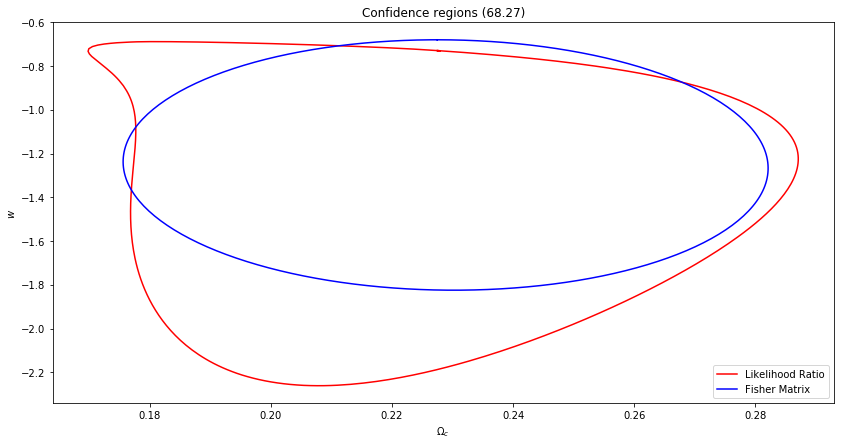

In [16]:
plt.figure (figsize=(14, 7))
plt.title ("Confidence regions (%.2f)" % (cr_rg.clevel * 100.0))
plt.plot (cr_p1array, cr_p2array, 'r', label="Likelihood Ratio")
plt.plot (fisher_p1array, fisher_p2array, 'b-', label="Fisher Matrix")

plt.xlabel(r'$\Omega_c$')
plt.ylabel(r'$w$')

plt.legend(loc=4)

plt.savefig ("snia_bao_rg_omegac_w.svg")